# Stock Market Forecast

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
data_df = pd.read_csv('data/train.csv')
data_df.head()

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
0,1,NaN,NaN,NaN,NaN,8.0,NaN,75751,0.2254,11.0,...,-0.002688,0.002246,-0.000838,-6.953224e-04,0.000003,-0.001974,-0.019512,0.028846,1.251508e+06,1.564385e+06
1,2,NaN,NaN,NaN,NaN,3.0,0.388896,17369,0.0166,13.0,...,-0.000129,0.000123,0.000248,3.315418e-07,0.000003,0.000027,-0.002939,-0.010253,1.733950e+06,2.167438e+06
2,3,NaN,-0.696727,0.739591,-0.167928,9.0,0.471947,8277,0.3650,9.0,...,-0.000524,-0.000394,0.000116,5.322557e-04,0.000274,0.000784,-0.024791,0.015711,1.529197e+06,1.911497e+06
3,4,NaN,-0.694350,1.568248,0.479073,5.0,0.120653,22508,0.2654,13.0,...,0.000346,-0.000090,0.000288,-1.281102e-04,0.000074,0.000341,-0.005680,-0.002190,1.711569e+06,2.139462e+06
4,5,6.0,-1.736489,2.765531,1.245280,7.0,4.866985,22423,0.2138,13.0,...,-0.001235,0.000027,0.002449,8.619882e-06,0.001209,-0.000004,0.036104,-0.026552,1.267270e+06,1.584088e+06


In [3]:
target_columns = ['Ret_121','Ret_122','Ret_123','Ret_124','Ret_125','Ret_126','Ret_127','Ret_128','Ret_129','Ret_130','Ret_131','Ret_132','Ret_133','Ret_134','Ret_135','Ret_136','Ret_137','Ret_138','Ret_139','Ret_140','Ret_141','Ret_142','Ret_143','Ret_144','Ret_145','Ret_146','Ret_147','Ret_148','Ret_149','Ret_150','Ret_151','Ret_152','Ret_153','Ret_154','Ret_155','Ret_156','Ret_157','Ret_158','Ret_159','Ret_160','Ret_161','Ret_162','Ret_163','Ret_164','Ret_165','Ret_166','Ret_167','Ret_168','Ret_169','Ret_170','Ret_171','Ret_172','Ret_173','Ret_174','Ret_175','Ret_176','Ret_177','Ret_178','Ret_179','Ret_180','Ret_PlusOne','Ret_PlusTwo','Weight_Intraday','Weight_Daily']

X = data_df.drop(target_columns, axis=1)
y = data_df[target_columns]
rows = data_df["Id"].count()

In [4]:
print(X.head())
print(y.head())

   Id  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   1        NaN        NaN        NaN        NaN        8.0        NaN   
1   2        NaN        NaN        NaN        NaN        3.0   0.388896   
2   3        NaN  -0.696727   0.739591  -0.167928        9.0   0.471947   
3   4        NaN  -0.694350   1.568248   0.479073        5.0   0.120653   
4   5        6.0  -1.736489   2.765531   1.245280        7.0   4.866985   

   Feature_7  Feature_8  Feature_9  ...   Ret_111   Ret_112   Ret_113  \
0      75751     0.2254       11.0  ...       NaN  0.000700 -0.000843   
1      17369     0.0166       13.0  ... -0.000010  0.000249  0.000492   
2       8277     0.3650        9.0  ...  0.000250 -0.000138 -0.000266   
3      22508     0.2654       13.0  ... -0.000571  0.000288  0.000006   
4      22423     0.2138       13.0  ... -0.000014  0.001210  0.000011   

    Ret_114   Ret_115   Ret_116   Ret_117   Ret_118   Ret_119       Ret_120  
0  0.000268 -0.000415 -0.001133 

In [5]:
X.columns[X.isnull().mean() > 0.2]

Index(['Feature_1', 'Feature_2', 'Feature_10'], dtype='object')

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.2):
        # Fraction of data allowed to be missing
        self.missing_threshold = threshold
        
    def fit(self, x, y=None):
        # Identify which columns to drop based on the missing data threshold set
        self.columns_to_drop = x.columns[x.isnull().mean() > self.missing_threshold]
        print(f"Finished fit ColumnDropper")
        return self
    
    def transform(self, x):
        # Drop the columns from the dataframe that exceed the missing data threshold
        temp = x.drop(columns=self.columns_to_drop)
        print(f"Finished transform ColumnDropper")
        return temp

data_df.dropna(axis=1, thresh=rows*0.8, inplace=True)

In [7]:
class DataFrameImputer(SimpleImputer):
    def fit(self, x, y=None):
        super().fit(x,y)
        self.feature_names = x.columns # Store lost feature names
        print(f"Finished fit DataFrameImputer")
        return self
    
    def transform(self, x):
        result = super().transform(x)
        print(f"Finished transform DataFrameImputer")
        return pd.DataFrame(result, columns=self.feature_names, index=x.index)

In [8]:
X.loc[:, X.isna().sum() > 0].info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 141 columns):
 #    Column      Non-Null Count  Dtype  
---   ------      --------------  -----  
 0    Feature_1   6687 non-null   float64
 1    Feature_2   30854 non-null  float64
 2    Feature_3   38763 non-null  float64
 3    Feature_4   32279 non-null  float64
 4    Feature_6   38067 non-null  float64
 5    Feature_8   39531 non-null  float64
 6    Feature_9   38125 non-null  float64
 7    Feature_10  20529 non-null  float64
 8    Feature_11  39013 non-null  float64
 9    Feature_12  38904 non-null  float64
 10   Feature_13  39406 non-null  float64
 11   Feature_14  39272 non-null  float64
 12   Feature_15  37859 non-null  float64
 13   Feature_16  39390 non-null  float64
 14   Feature_17  39354 non-null  float64
 15   Feature_18  39432 non-null  float64
 16   Feature_19  38810 non-null  float64
 17   Feature_20  32174 non-null  float64
 18   Feature_21  38982 non-null  float64
 19   Fe

In [9]:
# Features 
feature_columns = X.filter(like="Feature")
#feature_columns
feature_columns.iloc[:,1::].describe()

,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,...,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25
count,30854.000000,38763.000000,32279.000000,40000.000000,38067.000000,40000.000000,39531.000000,38125.000000,20529.000000,39013.000000,...,39390.000000,39354.000000,39432.000000,38810.000000,32174.000000,38982.000000,38655.000000,38289.000000,39274.000000,39345.000000
mean,-0.117558,0.558392,0.405572,5.482775,0.430972,49244.971525,0.196958,10.680289,4.744703,-0.572244,...,1.007362,-0.549725,0.803059,-1.205438,5.267359,0.605593,-0.773089,0.799833,-1.209290,-0.329675
std,1.236250,0.902233,0.799082,2.942324,1.498274,28242.409717,0.138485,2.850634,0.865096,1.246347,...,0.085488,0.936833,1.165442,0.642426,2.549227,1.319158,1.389229,1.288040,1.739656,0.958661
min,-3.440521,-4.643526,-5.440596,1.000000,-0.936644,338.000000,0.009800,0.000000,1.000000,-7.359120,...,1.000000,-2.613987,-5.758047,-3.292909,2.000000,-1.514998,-5.819912,-7.221387,-11.442205,-1.903876
25%,-0.967186,-0.110192,-0.111696,2.000000,-0.265555,26143.000000,0.016600,9.000000,5.000000,-1.115527,...,1.000000,-1.021216,0.057598,-1.619718,3.000000,-0.294925,-1.787615,0.539979,-1.838688,-0.830749
50%,-0.389162,0.437228,0.403516,6.000000,0.055564,48457.000000,0.213800,11.000000,5.000000,-0.324923,...,1.000000,-0.599050,0.587005,-1.169327,5.000000,0.308468,-0.699112,0.962580,-0.868435,-0.551550
75%,0.414442,1.064754,0.945944,8.000000,0.559921,72387.000000,0.331800,12.000000,5.000000,0.323631,...,1.000000,-0.184854,1.321231,-0.735786,7.000000,1.109743,0.282958,1.415303,-0.129465,-0.257543
max,4.175150,4.530405,2.953163,10.000000,12.609885,99861.000000,0.365000,36.000000,6.000000,1.786886,...,2.000000,7.683857,6.352352,0.898236,10.000000,7.737020,2.284991,3.228906,2.526654,4.020332


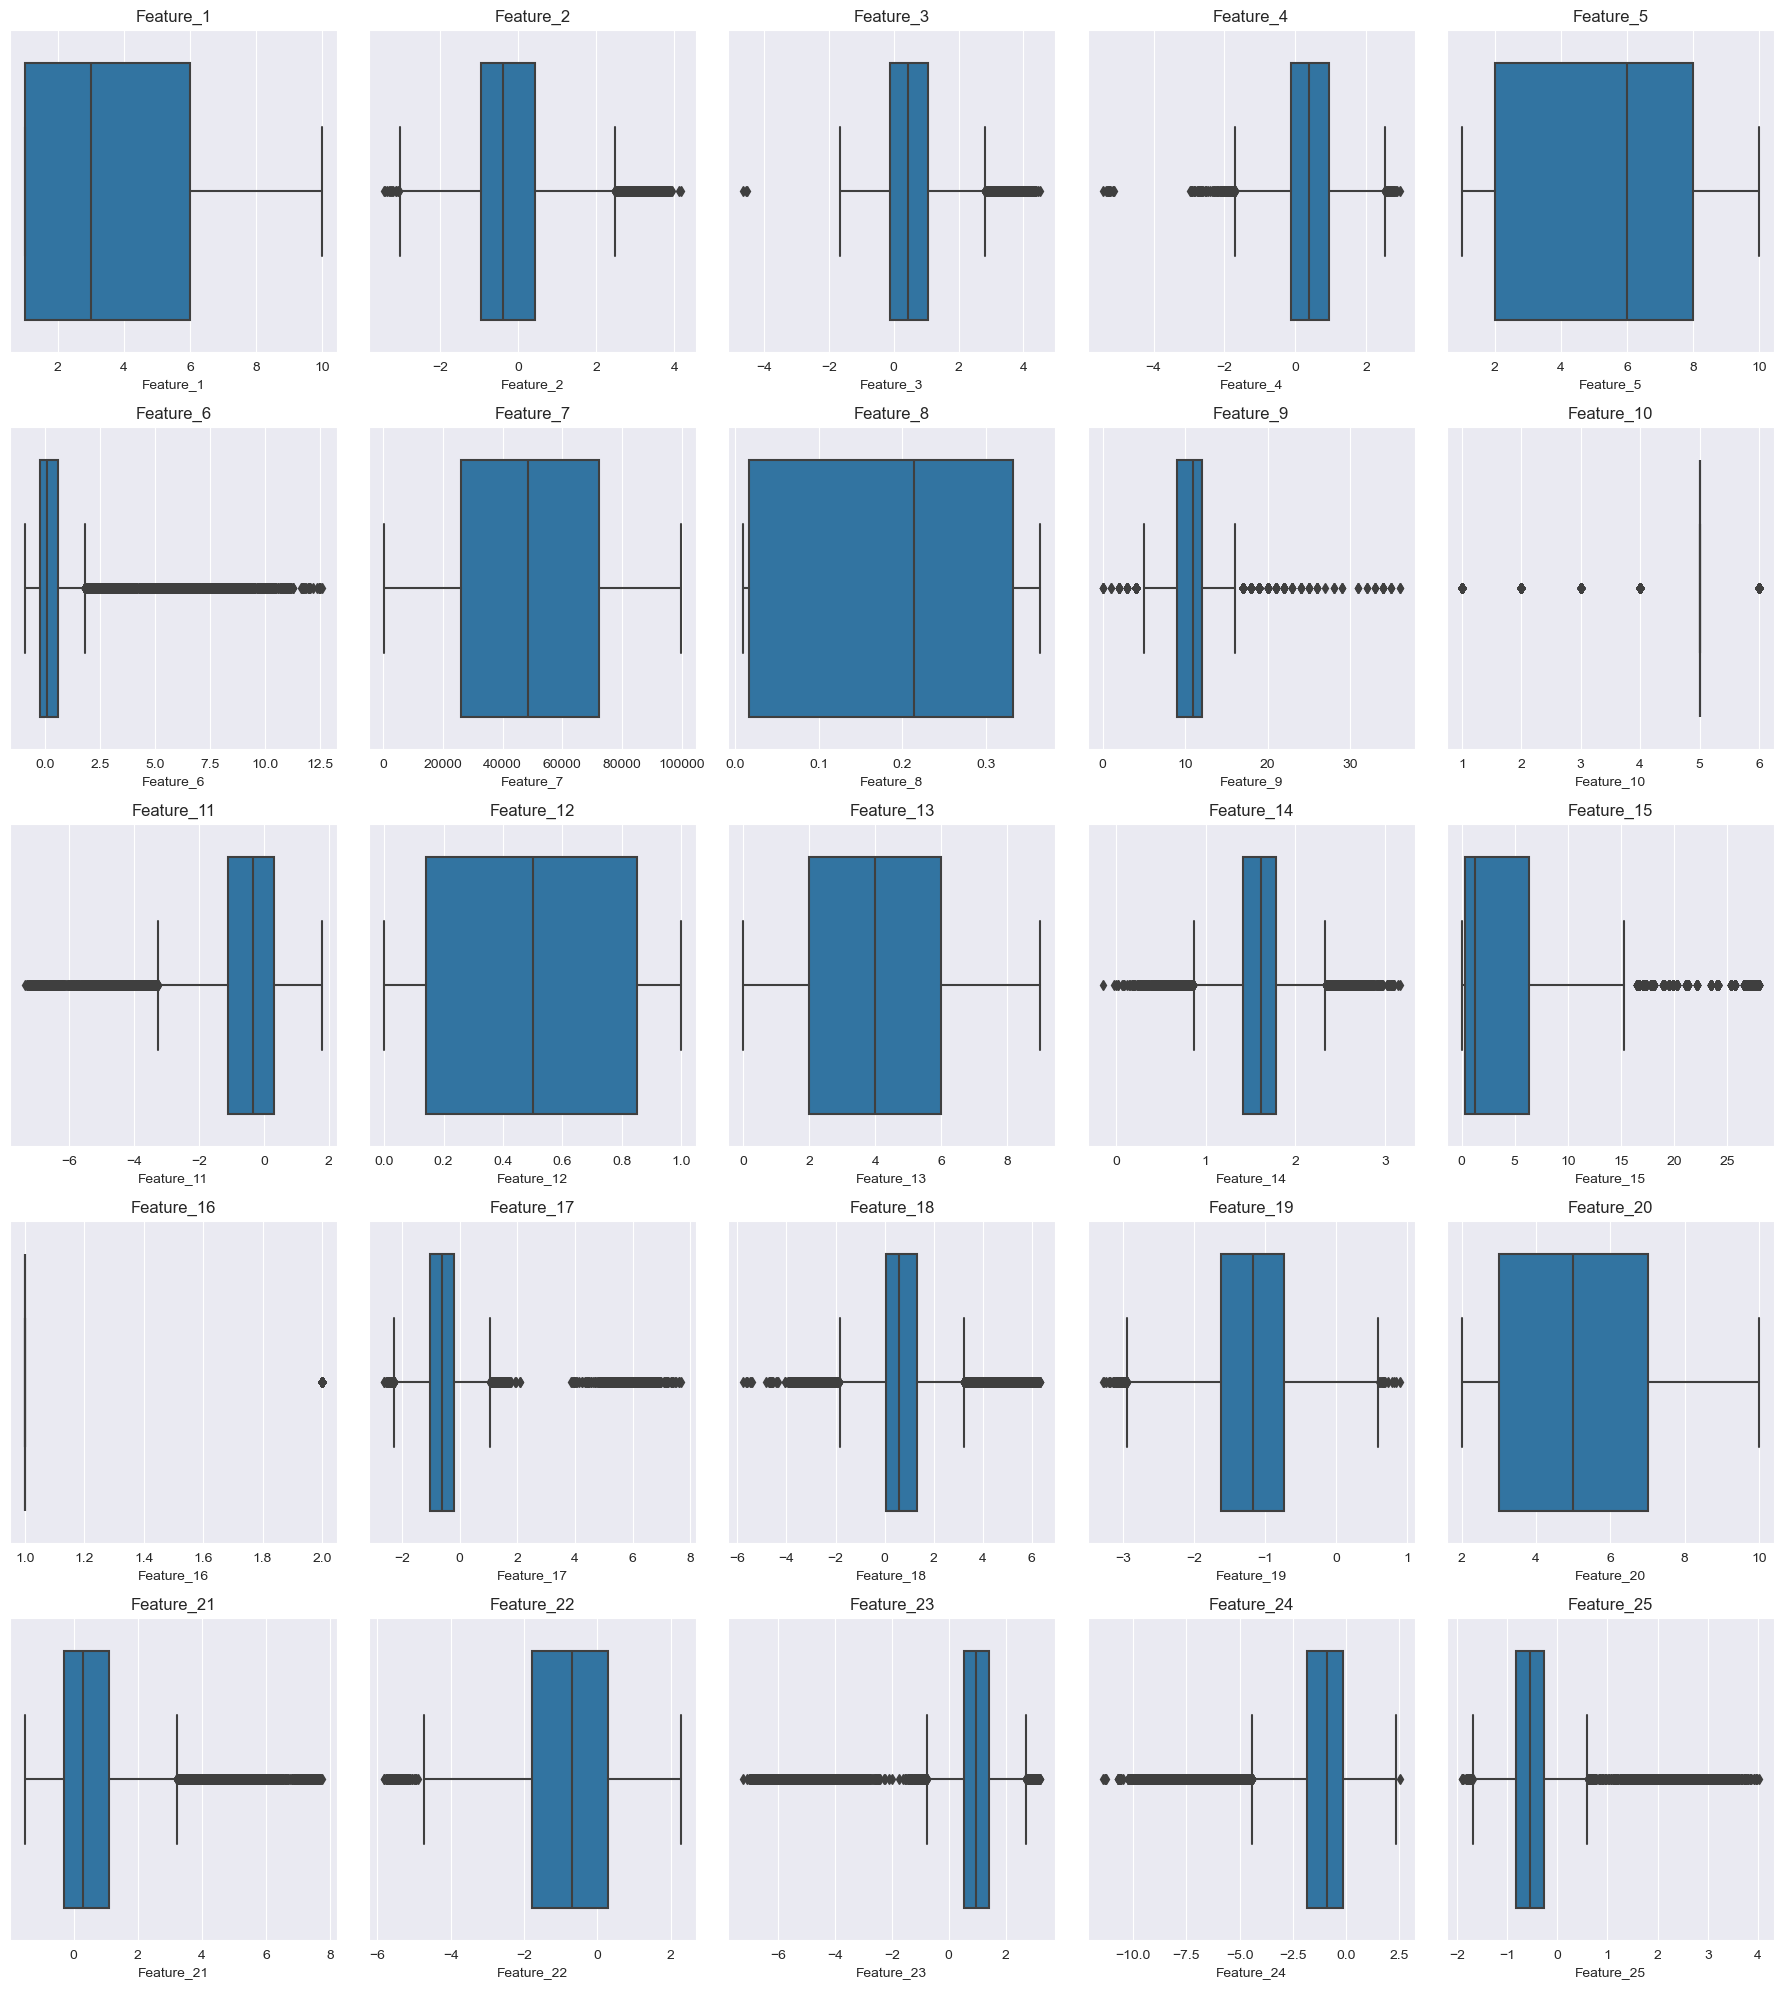

In [10]:
# View the feature data to investigate if the dataset contains outliers for a large number of columns. 

n_cols = 5
n_rows = 5

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 20))
axes = axes.flatten()

for i, column in enumerate(feature_columns.columns):
    sns.boxplot(x=feature_columns[column], ax=axes[i])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

As the dataset contains outliers in a vast number of the features but there is no context available in the features to tell if these outliers are errors or genuine data, capping will be performed on the upper and lower end of the features to reduce the influence of the extreme values while preserving that data points. 

In [11]:
class CapOutliers:
    def __init__(self):
        self.cap_values = dict()

    def fit(self, x, y=None):
        # Calculate the min and max cap values and store within a Dictionary
        feature_columns = x.filter(like="Feature")
        
        for column in feature_columns.columns:
            r1 = x[column].quantile(0.25)
            r3 = x[column].quantile(0.75)
            iqr = r3 - r1
            min_cap = r1 - 1.5 * iqr
            max_cap = r3 + 1.5 * iqr
            self.cap_values[column] = (min_cap, max_cap)
            
        print(f"Finished fit CapOutliers")

        return self
    
    def transform(self, x):
        # Apply the capping of values for each column
        x_capped = x.copy() # Avoid altering the original dataframe
        for column, (min_cap, max_cap) in self.cap_values.items():
            x_capped[column] = x_capped[column].clip(lower=min_cap, upper=max_cap)
            
        print(f"Finished transform CapOutliers")
        return x_capped

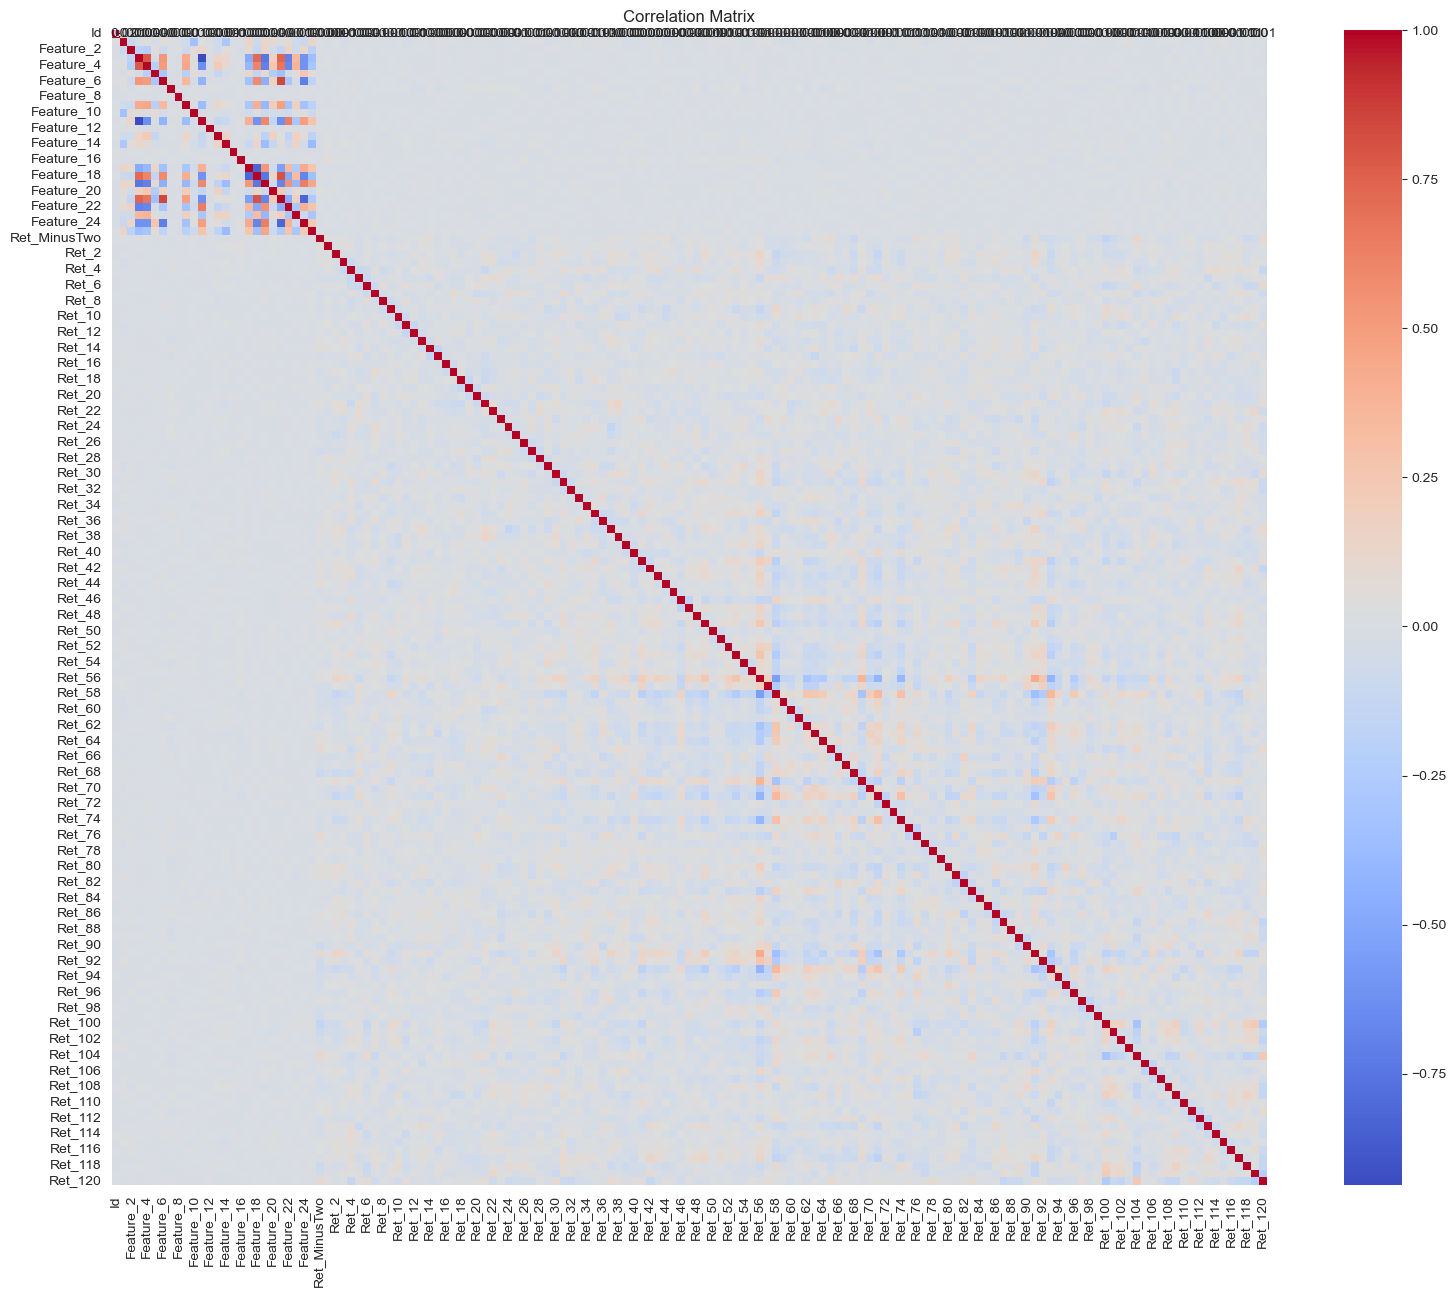

In [12]:
# Create a heatmap for the variables

corr_matrix = X.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix")
plt.show()

Due to the number of features the heatmap size has been reduced to not show all of the available features due to making the heatmap very difficult to read. From the image above it shows that there is no significant correlation between the variables used in this dataset and so there is no need to remove any of the variables when training the models

In [13]:
from sklearn.multioutput import MultiOutputRegressor

pipeline = Pipeline(steps=[
    ("drop_missing_columns", ColumnDropper(threshold=0.2)),
    ("replace_na", DataFrameImputer(strategy='mean')), # Replace missing values with the mean value for each column
    ("cap_outliers", CapOutliers()),
    ("normalize", MinMaxScaler()),
    #("feature_selection", SelectFromModel(MultiOutputRegressor(RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)))),
    ("classifier", RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42, verbose=2, n_jobs=-1)),
])

In [14]:
from sklearn.model_selection import train_test_split

### This needs reviewing as the point at which the weights are taken out needs to be thought over more. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_intraday_weight = y_train.iloc[:, -2]
train_daily_weight = y_train.iloc[:, -1]

test_intraday_weight = y_test.iloc[:,-2]
test_daily_weight = y_test.iloc[:,-1]

y_test = y_test.iloc[:,:-2]
y_train = y_train.iloc[:,:-2]

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

Finished fit ColumnDropper
Finished transform ColumnDropper
Finished fit DataFrameImputer
Finished transform DataFrameImputer
Finished fit CapOutliers
Finished transform CapOutliers


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.6s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [73]:
from sklearn.metrics import mean_squared_error

def calculate_wmae(y_true, y_pred):
    n = len(y_true)
    errors = (y_true - y_pred).abs()
    
    weighted_errors = errors.copy()
    weighted_errors.iloc[:, :59] = weighted_errors.iloc[:, :59].mul(test_intraday_weight, axis=0)
    weighted_errors.iloc[:, 59:] = weighted_errors.iloc[:, 59:].mul(test_daily_weight, axis=0)
    
    sum_weighted_errors = weighted_errors.sum().sum()
    sum_weights = pd.concat([test_intraday_weight]*59 + [test_daily_weight]*2, axis=1).sum().sum()
    
    weights_mae = sum_weighted_errors / sum_weights
    
    print(f"wmae: {weights_mae}")

In [27]:
calculate_wmae(y_test, y_pred)

wmae: 0.0011944451812764358


In [39]:
from sklearn.neural_network import MLPRegressor

mlp_pipeline = Pipeline(steps=[
    ("drop_missing_columns", ColumnDropper(threshold=0.2)),
    ("replace_na", DataFrameImputer(strategy='mean')), # Replace missing values with the mean value for each column
    ("cap_outliers", CapOutliers()),
    ("normalize", MinMaxScaler()),
    #("feature_selection", SelectFromModel(MultiOutputRegressor(RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)))),
    ("classifier", MLPRegressor(hidden_layer_sizes=(100,200,50), activation="relu", solver="adam", max_iter=300, random_state=42, verbose=True, n_iter_no_change=20, warm_start=True)),
])

In [40]:
pipeline.fit(X_train, y_train)
mlp_y_pred = pipeline.predict(X_test)

calculate_wmae(y_test, mlp_y_pred)

Finished fit ColumnDropper
Finished transform ColumnDropper
Finished fit DataFrameImputer
Finished transform DataFrameImputer
Finished fit CapOutliers
Finished transform CapOutliers
Iteration 1, loss = 0.00333527
Validation score: -539.712620
Iteration 2, loss = 0.00024798
Validation score: -186.101764
Iteration 3, loss = 0.00014000
Validation score: -114.924266
Iteration 4, loss = 0.00010709
Validation score: -76.046224
Iteration 5, loss = 0.00008863
Validation score: -54.564937
Iteration 6, loss = 0.00007580
Validation score: -38.037944
Iteration 7, loss = 0.00006774
Validation score: -29.683784
Iteration 8, loss = 0.00006292
Validation score: -24.363347
Iteration 9, loss = 0.00005949
Validation score: -20.233890
Iteration 10, loss = 0.00005728
Validation score: -18.037028
Iteration 11, loss = 0.00005527
Validation score: -15.641591
Iteration 12, loss = 0.00005377
Validation score: -14.271756
Iteration 13, loss = 0.00005259
Validation score: -12.357634
Iteration 14, loss = 0.00005152

In [41]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, mlp_y_pred)

0.001321861347667862

In [43]:
mean_absolute_error(y_test, y_pred)

0.0011146970143928825

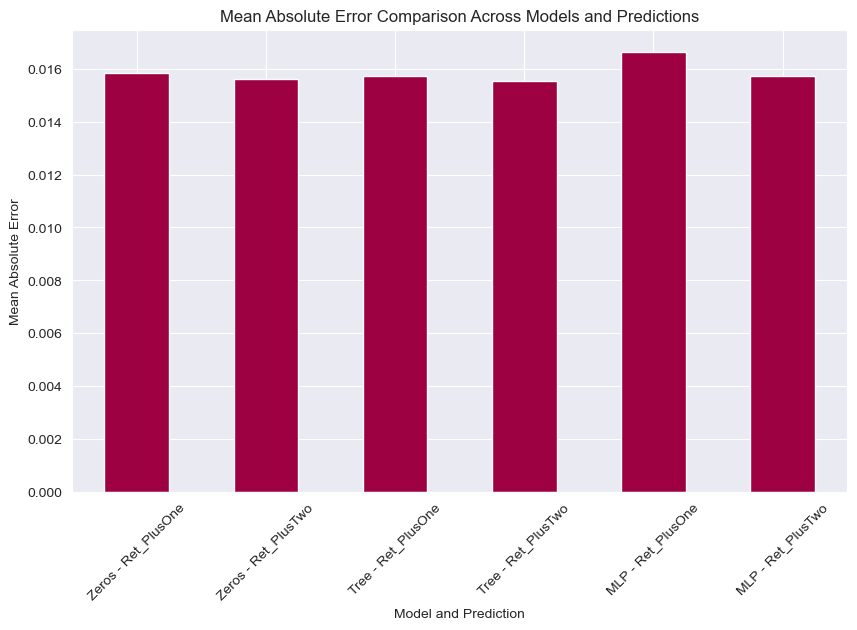

In [78]:
all_zero_predictions = pd.DataFrame(np.zeros_like(y_test))

true_results = y_test.iloc[:, -2:]
plusone_plustwo_zeros = all_zero_predictions.iloc[:, -2:]
plusone_plustwo_tree = pd.DataFrame(y_pred).iloc[:, -2:]
plusone_plustwo_mlp = pd.DataFrame(mlp_y_pred).iloc[:, -2:]

maes = {
    'Zeros - Ret_PlusOne': mean_absolute_error(true_results.iloc[:, 0], plusone_plustwo_zeros.iloc[:, 0]),
    'Zeros - Ret_PlusTwo': mean_absolute_error(true_results.iloc[:, 1], plusone_plustwo_zeros.iloc[:, 1]),
    'Tree - Ret_PlusOne': mean_absolute_error(true_results.iloc[:, 0], plusone_plustwo_tree.iloc[:, 0]),
    'Tree - Ret_PlusTwo': mean_absolute_error(true_results.iloc[:, 1], plusone_plustwo_tree.iloc[:, 1]),
    'MLP - Ret_PlusOne': mean_absolute_error(true_results.iloc[:, 0], plusone_plustwo_mlp.iloc[:, 0]),
    'MLP - Ret_PlusTwo': mean_absolute_error(true_results.iloc[:, 1], plusone_plustwo_mlp.iloc[:, 1])
}

# Preparing DataFrame for plotting
mae_df = pd.DataFrame(list(maes.items()), columns=['Model', 'MAE'])

fig, ax = plt.subplots(figsize=(10, 6))
mae_df.plot(kind='bar', ax=ax, x='Model', y='MAE', legend=False, colormap="Spectral")

ax.set_xlabel("Model and Prediction")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Mean Absolute Error Comparison Across Models and Predictions")
ax.set_xticklabels(mae_df['Model'], rotation=45)

plt.show()

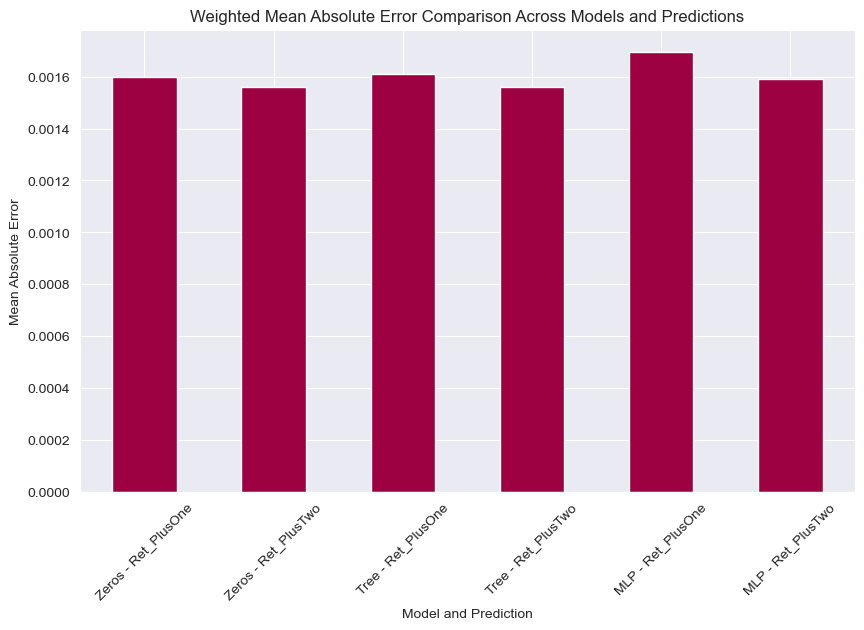

In [81]:
all_zero_predictions = pd.DataFrame(np.zeros_like(y_test))

true_results = y_test.iloc[:, -2:]
plusone_plustwo_zeros = all_zero_predictions.iloc[:, -2:]
plusone_plustwo_tree = pd.DataFrame(y_pred).iloc[:, -2:]
plusone_plustwo_mlp = pd.DataFrame(mlp_y_pred).iloc[:, -2:]

maes = {
    'Zeros - Ret_PlusOne': calculate_wmae_daily(true_results.iloc[:, 0], plusone_plustwo_zeros.iloc[:, 0]),
    'Zeros - Ret_PlusTwo': calculate_wmae_daily(true_results.iloc[:, 1], plusone_plustwo_zeros.iloc[:, 1]),
    'Tree - Ret_PlusOne': calculate_wmae_daily(true_results.iloc[:, 0], plusone_plustwo_tree.iloc[:, 0]),
    'Tree - Ret_PlusTwo': calculate_wmae_daily(true_results.iloc[:, 1], plusone_plustwo_tree.iloc[:, 1]),
    'MLP - Ret_PlusOne': calculate_wmae_daily(true_results.iloc[:, 0], plusone_plustwo_mlp.iloc[:, 0]),
    'MLP - Ret_PlusTwo': calculate_wmae_daily(true_results.iloc[:, 1], plusone_plustwo_mlp.iloc[:, 1])
}

# Preparing DataFrame for plotting
mae_df = pd.DataFrame(list(maes.items()), columns=['Model', 'MAE'])

fig, ax = plt.subplots(figsize=(10, 6))
mae_df.plot(kind='bar', ax=ax, x='Model', y='MAE', legend=False, colormap="Spectral")

ax.set_xlabel("Model and Prediction")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Weighted Mean Absolute Error Comparison Across Models and Predictions")
ax.set_xticklabels(mae_df['Model'], rotation=45)

plt.show()

In [80]:
def calculate_wmae_daily(y_true, y_pred):
    errors = (y_true - y_pred).abs()
    
    weighted_errors = errors.copy()
    weighted_errors = weighted_errors.mul(test_daily_weight, axis=0)
    
    sum_weighted_errors = weighted_errors.sum().sum()
    sum_weights = pd.concat([test_daily_weight]*2, axis=1).sum().sum()
    
    weights_mae = sum_weighted_errors / sum_weights
    
    return weights_mae